In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import re

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../")
from _utils import *

In [3]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 18) # fontsize of the x and y labels
plt.rc("axes", titlesize = 18) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

## Configuration

In [4]:
# Define the project analysis to visualize.
ANALYSIS_NAME = "Analysis 2022" #"Analysis 2021", "Analysis 2022", "Analysis 2022 (more splits)", "Analysis 2022 Same Time Length" 
PROJECT_ROOT = f"./RESULTS/{ANALYSIS_NAME}"

In [5]:
# Define country to analyze.
COUNTRY = "Nigeria"

# Define path to input and output folders.
DIR_RESULTS = f"{PROJECT_ROOT}/{COUNTRY}"
OUTPUT_FOLDER = f"{PROJECT_ROOT}/{COUNTRY}/standard/out_test/images"

## Load data

In [6]:
# Load forecasting results for each split.
xls = pd.ExcelFile(f"{DIR_RESULTS}/standard/out_test/forecast.xlsx")

forecast_splits = dict()
for i, sheet in enumerate(xls.sheet_names):
    if sheet != "FCG":
        forecast_split = pd.read_excel(xls, sheet, index_col = 0, header = [0, 1, 2])
        print(f"{sheet}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")
        # Reset the index.
        forecast_split.index = np.arange(1, len(forecast_split) + 1)
        forecast_split.index.names = ["Prediction horizon"]
        # Save the predictions.
        forecast_splits[sheet] = forecast_split
    
forecast_splits = pd.concat(forecast_splits, axis = 1)

Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02


In [7]:
# Load the training shapes for each split and prediction horizon.
training_shape = pd.read_csv(DIR_RESULTS + "/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)

# Load the losses for each split and province (model and naive).
loss_sites = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_sites.csv", index_col = [0, 1], header = [0, 1])

# Load the losses for each split and prediction horizon (model and naive).
loss_h = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])

# Load the r2 for each split and prediction horizon (model and naive).
r2_results = pd.read_csv(DIR_RESULTS + "/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])

# Load all the configurations tested during hyperpameter tuning.
hyper_params = pd.read_csv(DIR_RESULTS + "/standard/hyperparameter_tuning.csv")

## Figures

### R2 on validation set

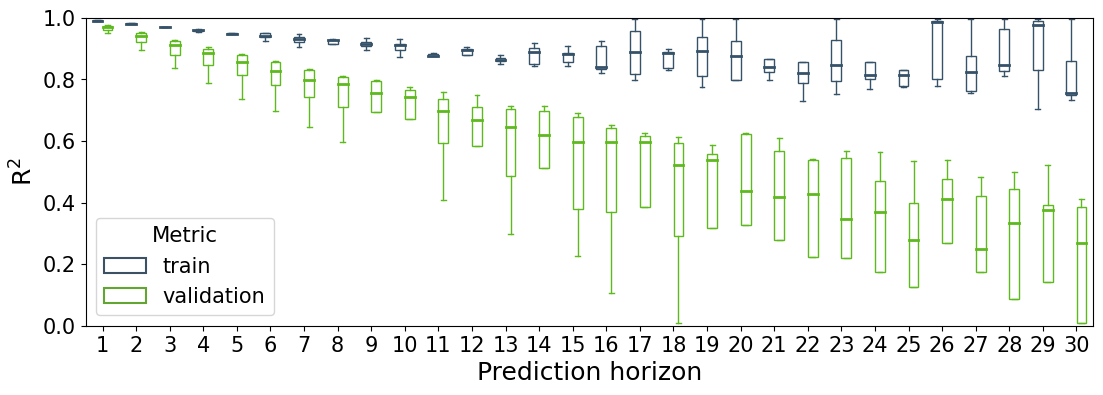

In [8]:
# For each split and prediction horizon, we get the best configuration according to the minimum of the 'loss_to_minimize'.
best_results = hyper_params.loc[hyper_params.groupby(["split", "h"])["loss_to_minimize"].idxmin()].set_index(["split", "h"])
# Get the r2 results corresponding to the best configurations.
best_r2 = best_results[["r2_train", "r2_val"]].unstack("split").reorder_levels([1, 0], axis = 1).sort_index(axis = 1, level = [0, 1])
best_r2.columns.names = ["split", "Metric"]
best_r2.rename({"r2_train": "train", "r2_val": "validation"}, axis = 1, level = "Metric", inplace = True)
best_r2 = pd.melt(best_r2, ignore_index=False).reset_index()

# Create boxplot r2 over all the splits.
fig, ax = plt.subplots(figsize = (13, 4)) 
colors = ["#355269", "#5eb91e"]
sns.boxplot(x="h", y="value", hue="Metric", data=best_r2, ax=ax, palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(ax, colors=colors)
    
ax.set_xlabel("Prediction horizon")
ax.set_ylabel("R$^2$")
ax.set_ylim(0, 1)

# Save figure.
fig.savefig(f"{OUTPUT_FOLDER}/r2_hyper.png" , bbox_inches = "tight", dpi = 300)

### R2 and loss metrics train and test

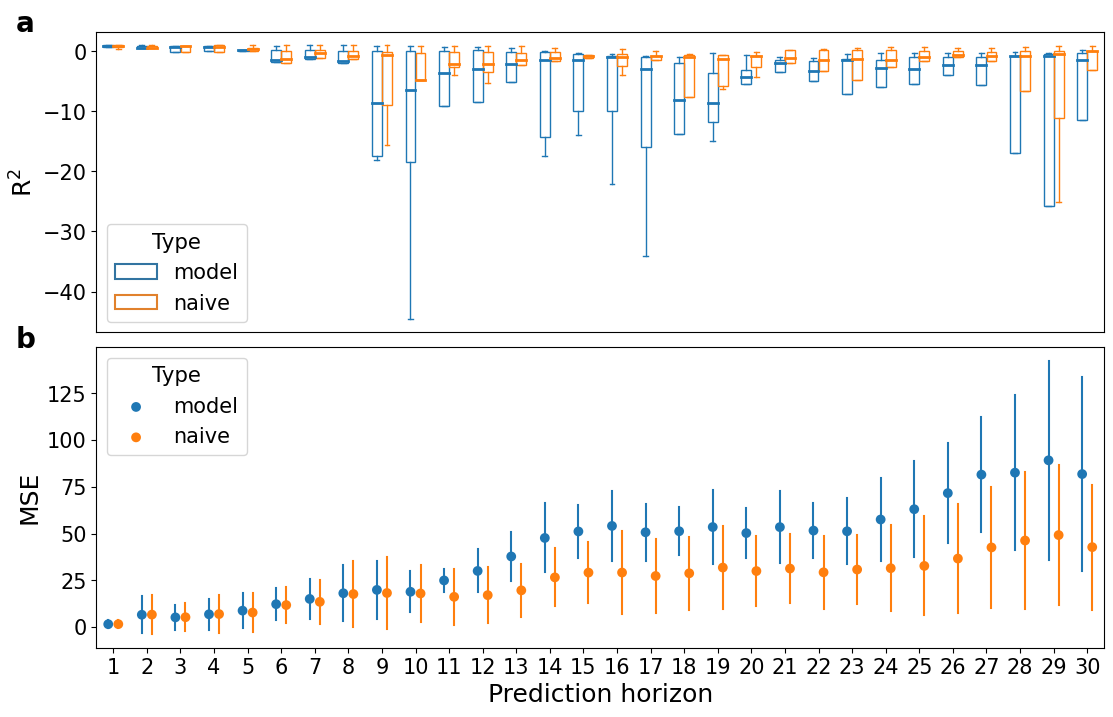

In [9]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 8), sharex = True)    
fig.subplots_adjust(hspace = .05)

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

# a) R2 scores as function of the prediction horizon.
r2_res = r2_results[COUNTRY]
r2_res.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_res = pd.melt(r2_res, ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", hue="Type", data=r2_res, ax=axs[0], palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(axs[0], colors=colors)

axs[0].set_ylabel("R$^2$")
axs[0].text(-0.08, 1., "a", transform = axs[0].transAxes, size = 20, weight = "bold")
    
# b) Total loss over the splits as function of the prediction horizon.
loss_h_res = loss_h.loc[COUNTRY]
loss_h_res.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)
loss_h_res = pd.melt(loss_h_res, ignore_index=False).reset_index()
        
sns.pointplot(x="Prediction horizon", y="value", hue="Type", ax=axs[1], data=loss_h_res, dodge=0.3, 
              linestyles=["", ""], ci="sd", estimator=np.mean, palette=colors, errwidth=1.5, scale=0.8)
    
axs[1].set_xlabel("Prediction horizon")
axs[1].set_ylabel("MSE")
axs[1].text(-0.08, 1, "b", transform = axs[1].transAxes, size = 20, weight = "bold")
        
axs[0].axes.get_xaxis().set_visible(False)
fig.savefig(f"{OUTPUT_FOLDER}/metrics_mix.png", bbox_inches = "tight", dpi = 300)

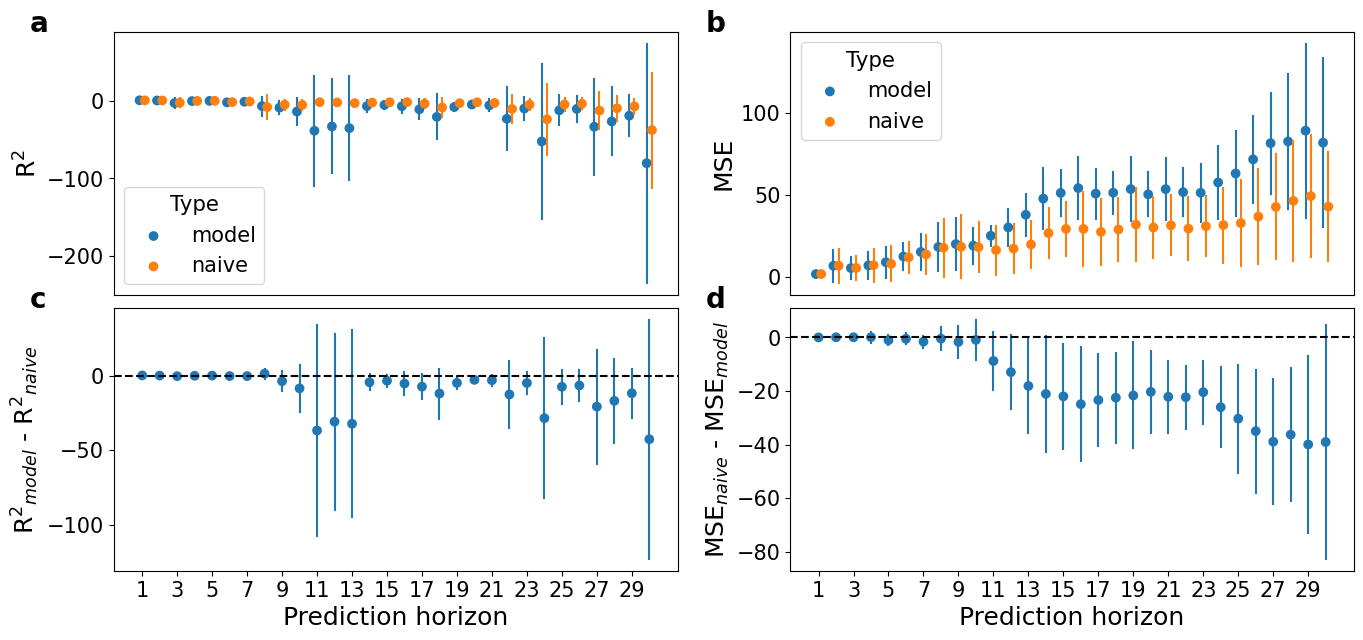

In [10]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 7), sharex = True)    
fig.subplots_adjust(hspace = .05)
axs = axs.ravel()

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

# a) R2 scores as function of the prediction horizon.
r2_res = r2_results[COUNTRY]
r2_res.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_res = pd.melt(r2_res, ignore_index=False).reset_index()

sns.pointplot(x="Prediction horizon", y="value", hue="Type", ax=axs[0], data=r2_res, dodge=0.3, 
              linestyles=["", ""], ci="sd", estimator=np.mean, palette=colors, errwidth=1.5, scale=0.8)
    
axs[0].set_ylabel("R$^2$")
axs[0].text(-0.15, 1., "a", transform = axs[0].transAxes, size = 20, weight = "bold")
axs[0].axes.get_xaxis().set_visible(False)
    
# b) Total loss over the splits as function of the prediction horizon.
loss_h_res = loss_h.loc[COUNTRY]
loss_h_res.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)
loss_h_res = pd.melt(loss_h_res, ignore_index=False).reset_index()
        
sns.pointplot(x="Prediction horizon", y="value", hue="Type", ax=axs[1], data=loss_h_res, dodge=0.3, 
              linestyles=["", ""], ci="sd", estimator=np.mean, palette=colors, errwidth=1.5, scale=0.8)
    
axs[1].set_xlabel("Prediction horizon")
axs[1].set_ylabel("MSE")
axs[1].text(-0.15, 1., "b", transform = axs[1].transAxes, size = 20, weight = "bold")
axs[1].axes.get_xaxis().set_visible(False)

# c) Compute R2 difference.
r2_results_diff = r2_results[COUNTRY].stack(["Split"])
r2_results_diff.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_results_diff["r2_difference"] = r2_results_diff["model"] - r2_results_diff["naive"]
r2_results_diff = pd.melt(r2_results_diff[["r2_difference"]], ignore_index=False).reset_index()

sns.pointplot(x="Prediction horizon", y="value", data=r2_results_diff, dodge=0.3, ax=axs[2], 
              linestyles=["", ""], ci="sd", estimator=np.mean, color=colors[0], errwidth=1.5, scale=0.8)

axs[2].axhline(y = 0, color = "black", linestyle = "--")
axs[2].set_xlabel("Prediction horizon")
axs[2].set_ylabel("R$^2$$_{model}$ - R$^2$$_{naive}$")
axs[2].text(-0.15, 1., "c", transform = axs[2].transAxes, size = 20, weight = "bold")

# d) Compute loss difference.
loss_h_diff = loss_h.loc[COUNTRY].stack(["Split"])
loss_h_diff.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = "Type", inplace = True)
loss_h_diff["mse_difference"] = loss_h_diff["naive"] - loss_h_diff["model"]
loss_h_diff = pd.melt(loss_h_diff[["mse_difference"]], ignore_index=False).reset_index()

sns.pointplot(x="Prediction horizon", y="value", data=loss_h_diff, dodge=0.3, ax=axs[3], 
              linestyles=["", ""], ci="sd", estimator=np.mean, color=colors[0], errwidth=1.5, scale=0.8)

axs[3].axhline(y = 0, color = "black", linestyle = "--")
axs[3].set_xlabel("Prediction horizon")
axs[3].set_ylabel("MSE$_{naive}$ - MSE$_{model}$")
axs[3].text(-0.15, 1., "d", transform = axs[3].transAxes, size = 20, weight = "bold")

plt.locator_params(axis="x", nbins=20)

fig.savefig(f"{OUTPUT_FOLDER}/metrics_pointplot.png", bbox_inches = "tight", dpi = 300)

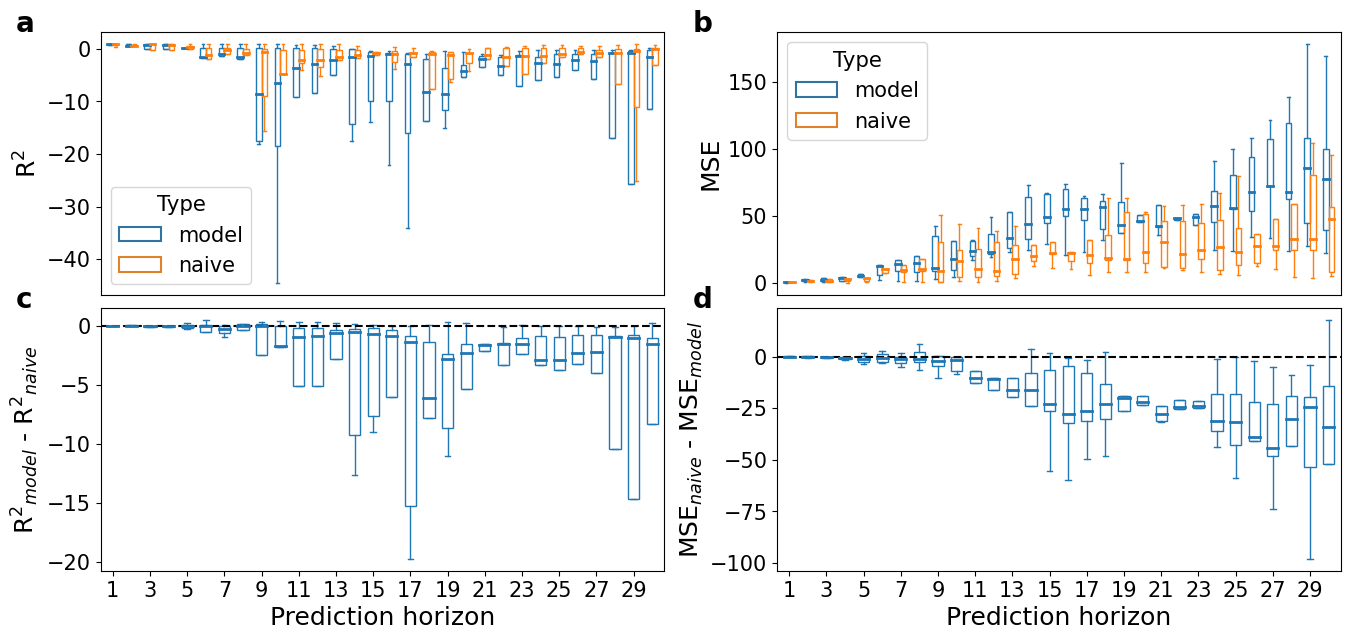

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 7), sharex = True)    
fig.subplots_adjust(hspace = .05)
axs = axs.ravel()

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

# a) R2 scores as function of the prediction horizon.
r2_res = r2_results[COUNTRY]
r2_res.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_res = pd.melt(r2_res, ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", hue="Type", data=r2_res, ax=axs[0], palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(axs[0], colors=colors)
    
axs[0].set_ylabel("R$^2$")
axs[0].text(-0.15, 1., "a", transform = axs[0].transAxes, size = 20, weight = "bold")
axs[0].axes.get_xaxis().set_visible(False)
    
# b) Total loss over the splits as function of the prediction horizon.
loss_h_res = loss_h.loc[COUNTRY]
loss_h_res.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)
loss_h_res = pd.melt(loss_h_res, ignore_index=False).reset_index()
        
sns.boxplot(x="Prediction horizon", y="value", hue="Type", data=loss_h_res, ax=axs[1], palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(axs[1], colors=colors)
    
axs[1].set_xlabel("Prediction horizon")
axs[1].set_ylabel("MSE")
axs[1].text(-0.15, 1., "b", transform = axs[1].transAxes, size = 20, weight = "bold")
axs[1].axes.get_xaxis().set_visible(False)

# c) Compute R2 difference.
r2_results_diff = r2_results[COUNTRY].stack(["Split"])
r2_results_diff.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_results_diff["r2_difference"] = r2_results_diff["model"] - r2_results_diff["naive"]
r2_results_diff = pd.melt(r2_results_diff[["r2_difference"]], ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", data=r2_results_diff, ax=axs[2], color=colors[0], 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(axs[2], colors=[colors[0]])

axs[2].axhline(y = 0, color = "black", linestyle = "--")
axs[2].set_xlabel("Prediction horizon")
axs[2].set_ylabel("R$^2$$_{model}$ - R$^2$$_{naive}$")
axs[2].text(-0.15, 1., "c", transform = axs[2].transAxes, size = 20, weight = "bold")

# d) Compute loss difference.
loss_h_diff = loss_h.loc[COUNTRY].stack(["Split"])
loss_h_diff.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = "Type", inplace = True)
loss_h_diff["mse_difference"] = loss_h_diff["naive"] - loss_h_diff["model"]
loss_h_diff = pd.melt(loss_h_diff[["mse_difference"]], ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", data=loss_h_diff, ax=axs[3], color=colors[0], 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(axs[3], colors=[colors[0]])

axs[3].axhline(y = 0, color = "black", linestyle = "--")
axs[3].set_xlabel("Prediction horizon")
axs[3].set_ylabel("MSE$_{naive}$ - MSE$_{model}$")
axs[3].text(-0.15, 1., "d", transform = axs[3].transAxes, size = 20, weight = "bold")

plt.locator_params(axis="x", nbins=20)

fig.savefig(f"{OUTPUT_FOLDER}/metrics_boxplot.png", bbox_inches = "tight", dpi = 300)

### Scatterpot: actual vs forecast

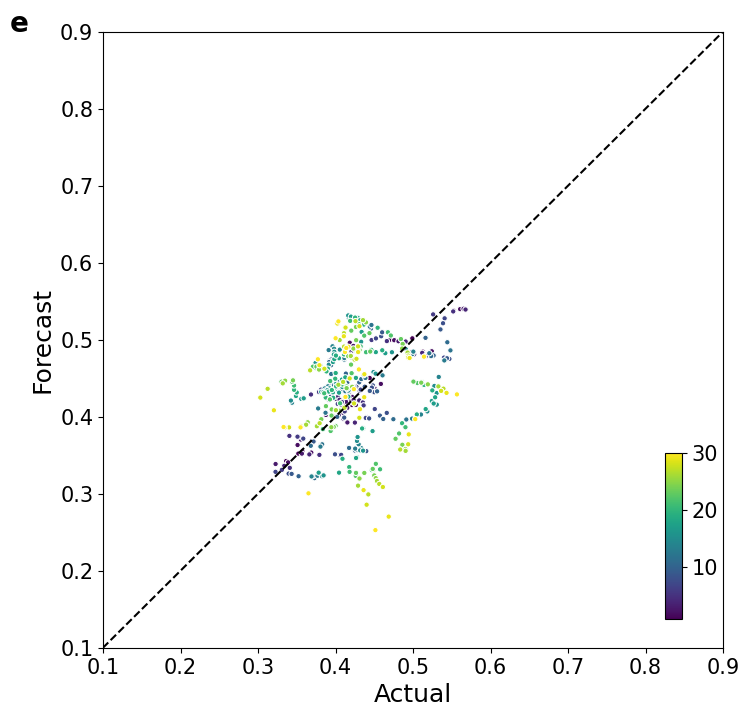

In [12]:
# Actual vs Forecast
predictions = forecast_splits.xs(COUNTRY, axis = 1, level = 1)#.columns.get_level_values(1).unique()
predictions = predictions.drop(["Naive"], axis = 1, level = 2)
predictions = predictions/100
predictions = predictions.stack([0,1]).reset_index(level = "Prediction horizon")
predictions.rename({"FCG": "Actual"}, axis = 1, inplace = True)

fig, ax = plt.subplots(figsize = (8, 8))
# Add bisector.
ax.plot(ax.get_xlim(), ax.get_ylim(), color = "black", linestyle = "--")

sns.scatterplot(data = predictions, x="Actual", y = "Forecast", hue = "Prediction horizon", s = 15, ax = ax, 
                legend = False, palette = "viridis")

# Legend.
ax.set_xlim(0.1, 0.9)
ax.set_ylim(0.1, 0.9)

norm = plt.Normalize(1, 30)
sm = plt.cm.ScalarMappable(cmap = "viridis", norm = norm)
sm.set_array([])
cbaxes = inset_axes(ax, width = "3%", height = "30%", loc = "lower right", bbox_to_anchor = (0.05,0.03,.9,.9), 
                    bbox_transform = ax.transAxes) 
ax.figure.colorbar(sm, cax = cbaxes)

ax.text(-0.15, 1., "e", transform = ax.transAxes, size = 20, weight = "bold")

fig.savefig(f"{OUTPUT_FOLDER}/scatterplot.png", bbox_inches = "tight", dpi = 300)

### Forecasting results

In [13]:
# Load forecasting results.
xls = pd.ExcelFile(f"{DIR_RESULTS}/standard/out_test/forecast.xlsx")
fcg = pd.read_excel(xls, "FCG", index_col = 0, header = [0, 1, 2])

forecasts = dict()
for sheet in xls.sheet_names:
    if sheet != "FCG":
        forecast_split = pd.read_excel(xls, sheet, index_col = 0, header = [0, 1, 2])
        forecast_split.drop("FCG", axis = 1, level = 2, inplace = True)
        forecast_split = pd.concat([fcg, forecast_split], axis = 1).sort_index(axis = 1, level = [0, 1, 2])
        # Save the predictions.
        forecasts[sheet] = forecast_split
    
forecasts = pd.concat(forecasts, axis = 1)
forecasts.columns.names = ["Split", "Country", "AdminStrata", "Prediction"]
forecasts.head()

Split          Split 1                                                      \
Country        Nigeria                                                       
AdminStrata    Adamawa                     Borno                      Yobe   
Prediction         FCG Forecast Naive        FCG Forecast Naive        FCG   
Datetime                                                                     
2019-01-18   23.586938      NaN   NaN  37.455808      NaN   NaN  30.722900   
2019-01-19   22.755425      NaN   NaN  36.451190      NaN   NaN  30.273423   
2019-01-20   22.547817      NaN   NaN  36.461960      NaN   NaN  31.047474   
2019-01-21   23.758271      NaN   NaN  36.892211      NaN   NaN  31.814861   
2019-01-22   22.374279      NaN   NaN  35.637055      NaN   NaN  30.674752   

Split                         Split 2  ... Split 4    Split 5                 \
Country                       Nigeria  ... Nigeria    Nigeria                  
AdminStrata                   Adamawa  ...    Yobe    Adamawa                  
Prediction  Forecast Naive        FCG  ...   Naive        FCG Forecast Naive   
Datetime                               ...                                     
2019-01-18       NaN   NaN  23.586938  ...     NaN  23.586938      NaN   NaN   
2019-01-19       NaN   NaN  22.755425  ...     NaN  22.755425      NaN   NaN   
2019-01-20       NaN   NaN  22.547817  ...     NaN  22.547817      NaN   NaN   
2019-01-21       NaN   NaN  23.758271  ...     NaN  23.758271      NaN   NaN   
2019-01-22       NaN   NaN  22.374279  ...     NaN  22.374279      NaN   NaN   

Split                                                            
Country                                                          
AdminStrata      Borno                      Yobe                 
Prediction         FCG Forecast Naive        FCG Forecast Naive  
Datetime                                                         
2019-01-18   37.455808      NaN   NaN  30.722900      NaN   NaN  
2019-01-19   36.451190      NaN   NaN  30.273423      NaN   NaN  
2019-01-20   36.461960      NaN   NaN  31.047474      NaN   NaN  
2019-01-21   36.892211      NaN   NaN  31.814861      NaN   NaN  
2019-01-22   35.637055      NaN   NaN  30.674752      NaN   NaN  

[5 rows x 45 columns]

In [14]:
from _predictions import get_regions

# Some example of predictions for visualization (paper).
REGIONS_PRED = get_regions(ANALYSIS_NAME)

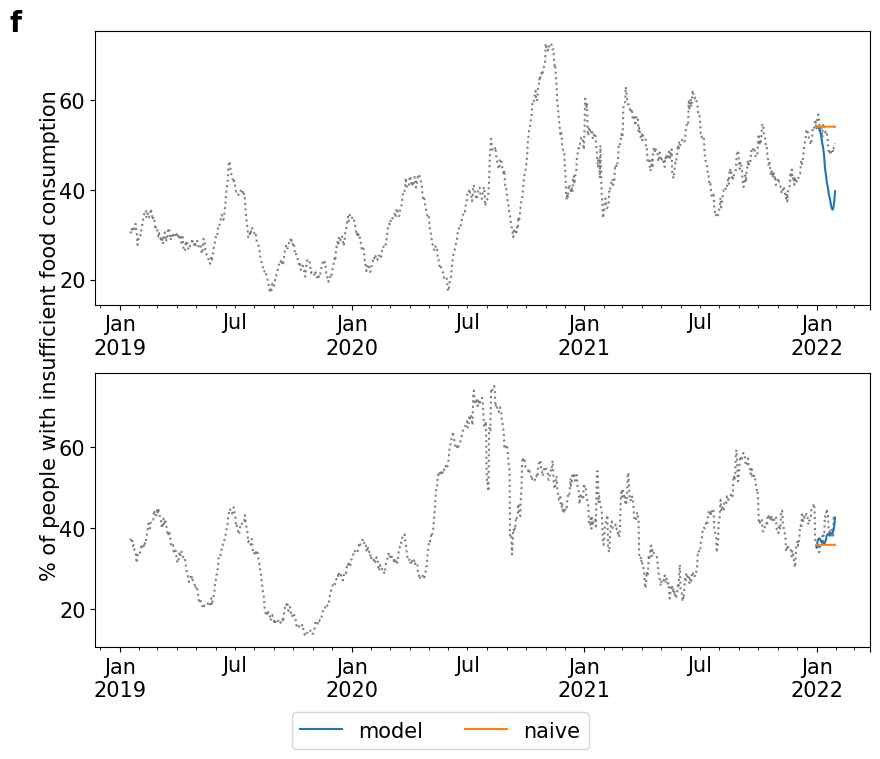

In [15]:
# Forecasting results for paper.
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 8))    
fig.subplots_adjust(hspace = .25)

plot_prediction(forecasts, REGIONS_PRED[COUNTRY][0][0], COUNTRY, REGIONS_PRED[COUNTRY][0][1], axs[0])
plot_prediction(forecasts, REGIONS_PRED[COUNTRY][1][0], COUNTRY, REGIONS_PRED[COUNTRY][1][1], axs[1])

fig.text(0.07, 0.5, "% of people with insufficient food consumption", va = "center", rotation = "vertical", 
         fontdict = {"size": 15})
axs.flatten()[0].get_legend().remove()
axs.flatten()[-1].legend(bbox_to_anchor = (0.65, -0.2), ncol = 2)

axs[0].text(-0.11, 1., "f", transform = axs[0].transAxes, size = 20, weight = "bold")

fig.savefig(f"{OUTPUT_FOLDER}/predictions.png", bbox_inches = "tight", dpi = 300)

### Full panel

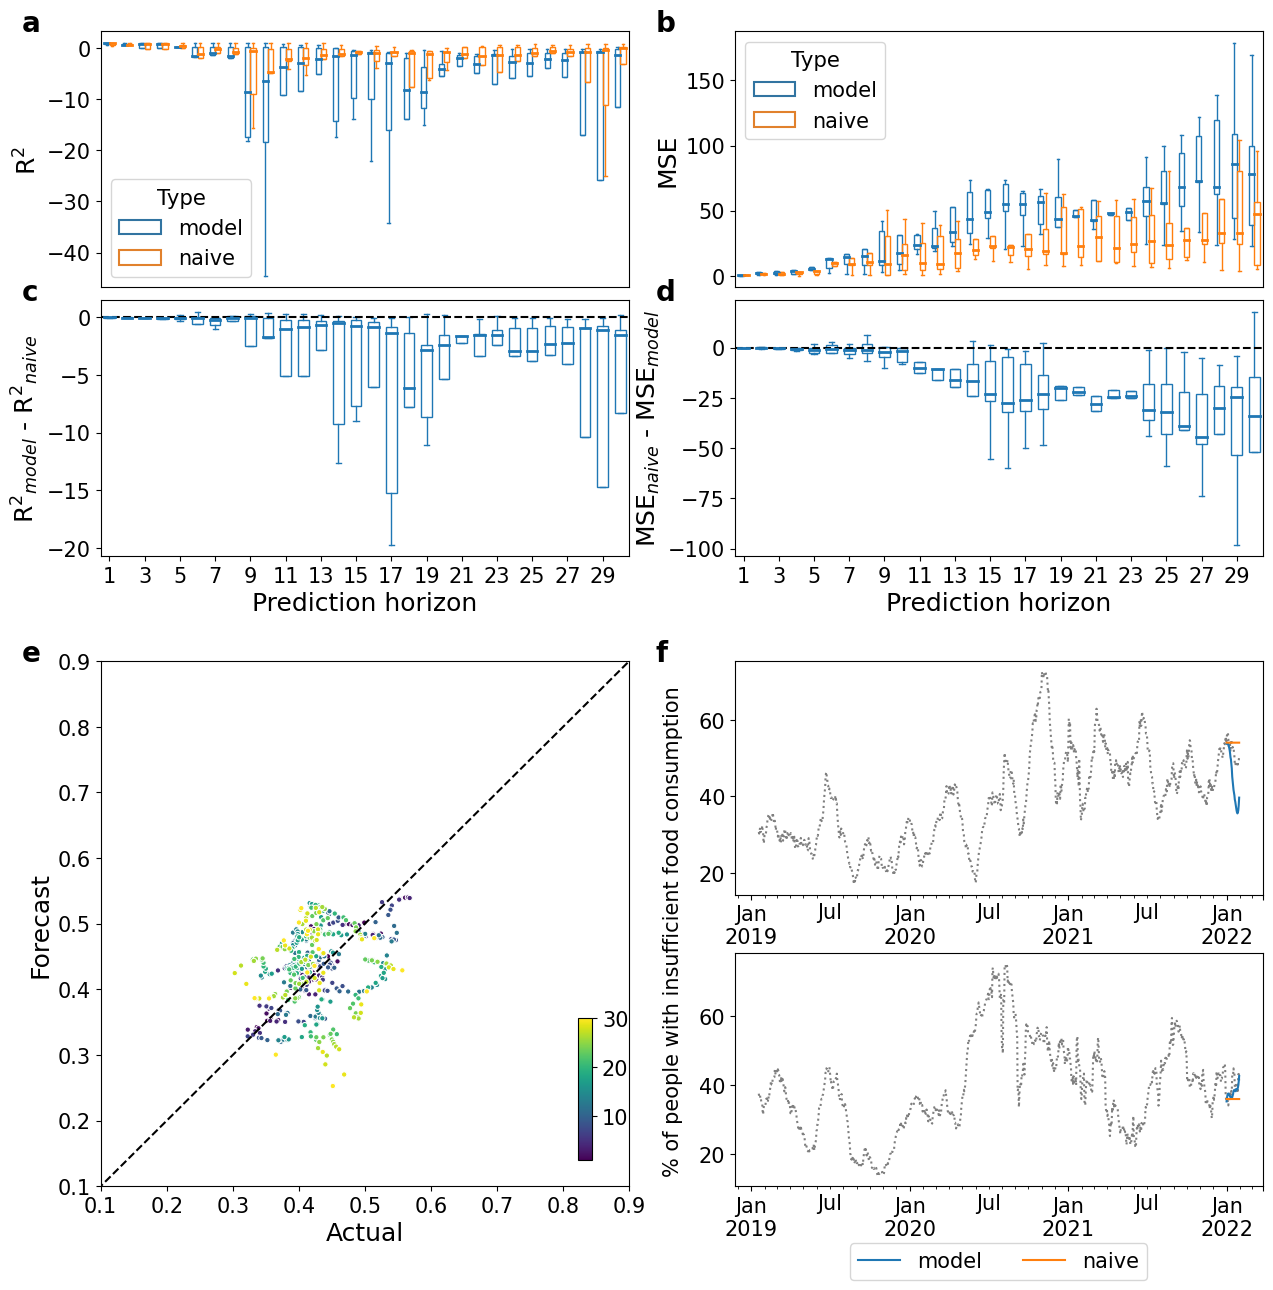

In [16]:
fig = plt.figure(figsize = (15, 15))
gs = gridspec.GridSpec(nrows=2, ncols=2)
#fig.subplots_adjust(hspace = .05)

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

# a) R2 scores as function of the prediction horizon.
gs00 = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=gs[0,:], hspace=.05)
ax0 = fig.add_subplot(gs00[0, 0])
r2_res = r2_results[COUNTRY]
r2_res.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_res = pd.melt(r2_res, ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", hue="Type", data=r2_res, ax=ax0, palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(ax0, colors=colors)
    
ax0.set_ylabel("R$^2$")
ax0.text(-0.15, 1., "a", transform = ax0.transAxes, size = 20, weight = "bold")
ax0.axes.get_xaxis().set_visible(False)
    
# b) Total loss over the splits as function of the prediction horizon.
ax1 = fig.add_subplot(gs00[0, 1])
loss_h_res = loss_h.loc[COUNTRY]
loss_h_res.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)
loss_h_res = pd.melt(loss_h_res, ignore_index=False).reset_index()
        
sns.boxplot(x="Prediction horizon", y="value", hue="Type", data=loss_h_res, ax=ax1, palette=colors, 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(ax1, colors=colors)
    
ax1.set_xlabel("Prediction horizon")
ax1.set_ylabel("MSE")
ax1.text(-0.15, 1., "b", transform = ax1.transAxes, size = 20, weight = "bold")
ax1.axes.get_xaxis().set_visible(False)

# c) Compute R2 difference.
ax2 = fig.add_subplot(gs00[1, 0])
r2_results_diff = r2_results[COUNTRY].stack(["Split"])
r2_results_diff.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = "Type", inplace = True)
r2_results_diff["r2_difference"] = r2_results_diff["model"] - r2_results_diff["naive"]
r2_results_diff = pd.melt(r2_results_diff[["r2_difference"]], ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", data=r2_results_diff, ax=ax2, color=colors[0], 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(ax2, colors=[colors[0]])

ax2.axhline(y = 0, color = "black", linestyle = "--")
ax2.set_xlabel("Prediction horizon")
ax2.set_ylabel("R$^2$$_{model}$ - R$^2$$_{naive}$")
ax2.text(-0.15, 1., "c", transform = ax2.transAxes, size = 20, weight = "bold")

# d) Compute loss difference.
ax3 = fig.add_subplot(gs00[1, 1])
loss_h_diff = loss_h.loc[COUNTRY].stack(["Split"])
loss_h_diff.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = "Type", inplace = True)
loss_h_diff["mse_difference"] = loss_h_diff["naive"] - loss_h_diff["model"]
loss_h_diff = pd.melt(loss_h_diff[["mse_difference"]], ignore_index=False).reset_index()

sns.boxplot(x="Prediction horizon", y="value", data=loss_h_diff, ax=ax3, color=colors[0], 
            showfliers=False, linewidth=1., medianprops={"linewidth": 2}, width=0.6)
adjust_boxplot(ax3, colors=[colors[0]])

ax3.axhline(y = 0, color = "black", linestyle = "--")
ax3.set_xlabel("Prediction horizon")
ax3.set_ylabel("MSE$_{naive}$ - MSE$_{model}$")
ax3.text(-0.15, 1., "d", transform = ax3.transAxes, size = 20, weight = "bold")

ax2.locator_params(axis="x", nbins=20)
ax3.locator_params(axis="x", nbins=20)

# e) Actual vs Forecast
gs01 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs[1,0])
ax4 = fig.add_subplot(gs01[0, 0])
predictions = forecast_splits.xs(COUNTRY, axis = 1, level = 1)#.columns.get_level_values(1).unique()
predictions = predictions.drop(["Naive"], axis = 1, level = 2)
predictions = predictions/100
predictions = predictions.stack([0,1]).reset_index(level = "Prediction horizon")
predictions.rename({"FCG": "Actual"}, axis = 1, inplace = True)

ax4.plot(ax4.get_xlim(), ax4.get_ylim(), color = "black", linestyle = "--")

sns.scatterplot(data = predictions, x="Actual", y = "Forecast", hue = "Prediction horizon", s = 15, ax = ax4, 
                legend = False, palette = "viridis")

ax4.set_xlim(0.1, 0.9)
ax4.set_ylim(0.1, 0.9)

norm = plt.Normalize(1, 30)
sm = plt.cm.ScalarMappable(cmap = "viridis", norm = norm)
sm.set_array([])
cbaxes = inset_axes(ax4, width = "3%", height = "30%", loc = "lower right", bbox_to_anchor = (0.05,0.03,.9,.9), 
                    bbox_transform = ax4.transAxes) 
ax4.figure.colorbar(sm, cax = cbaxes)

ax4.text(-0.15, 1., "e", transform = ax4.transAxes, size = 20, weight = "bold")

# f) Predictions.
gs02 = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs[1,1], hspace=.25)
ax5 = fig.add_subplot(gs02[0, 0])
ax6 = fig.add_subplot(gs02[1, 0])
plot_prediction(forecasts, REGIONS_PRED[COUNTRY][0][0], COUNTRY, REGIONS_PRED[COUNTRY][0][1], ax5)
plot_prediction(forecasts, REGIONS_PRED[COUNTRY][1][0], COUNTRY, REGIONS_PRED[COUNTRY][1][1], ax6)

ax5.text(-0.15, 1., "f", transform = ax5.transAxes, size = 20, weight = "bold")

ax5.get_legend().remove()
ax6.legend(bbox_to_anchor = (0.8, -0.2), ncol = 2)

fig.text(0.5, 0.28, "% of people with insufficient food consumption", va = "center", rotation = "vertical", 
         fontdict = {"size": 15})

fig.savefig(f"{OUTPUT_FOLDER}/full_panel.png", bbox_inches = "tight", dpi = 300)

### Feature importance

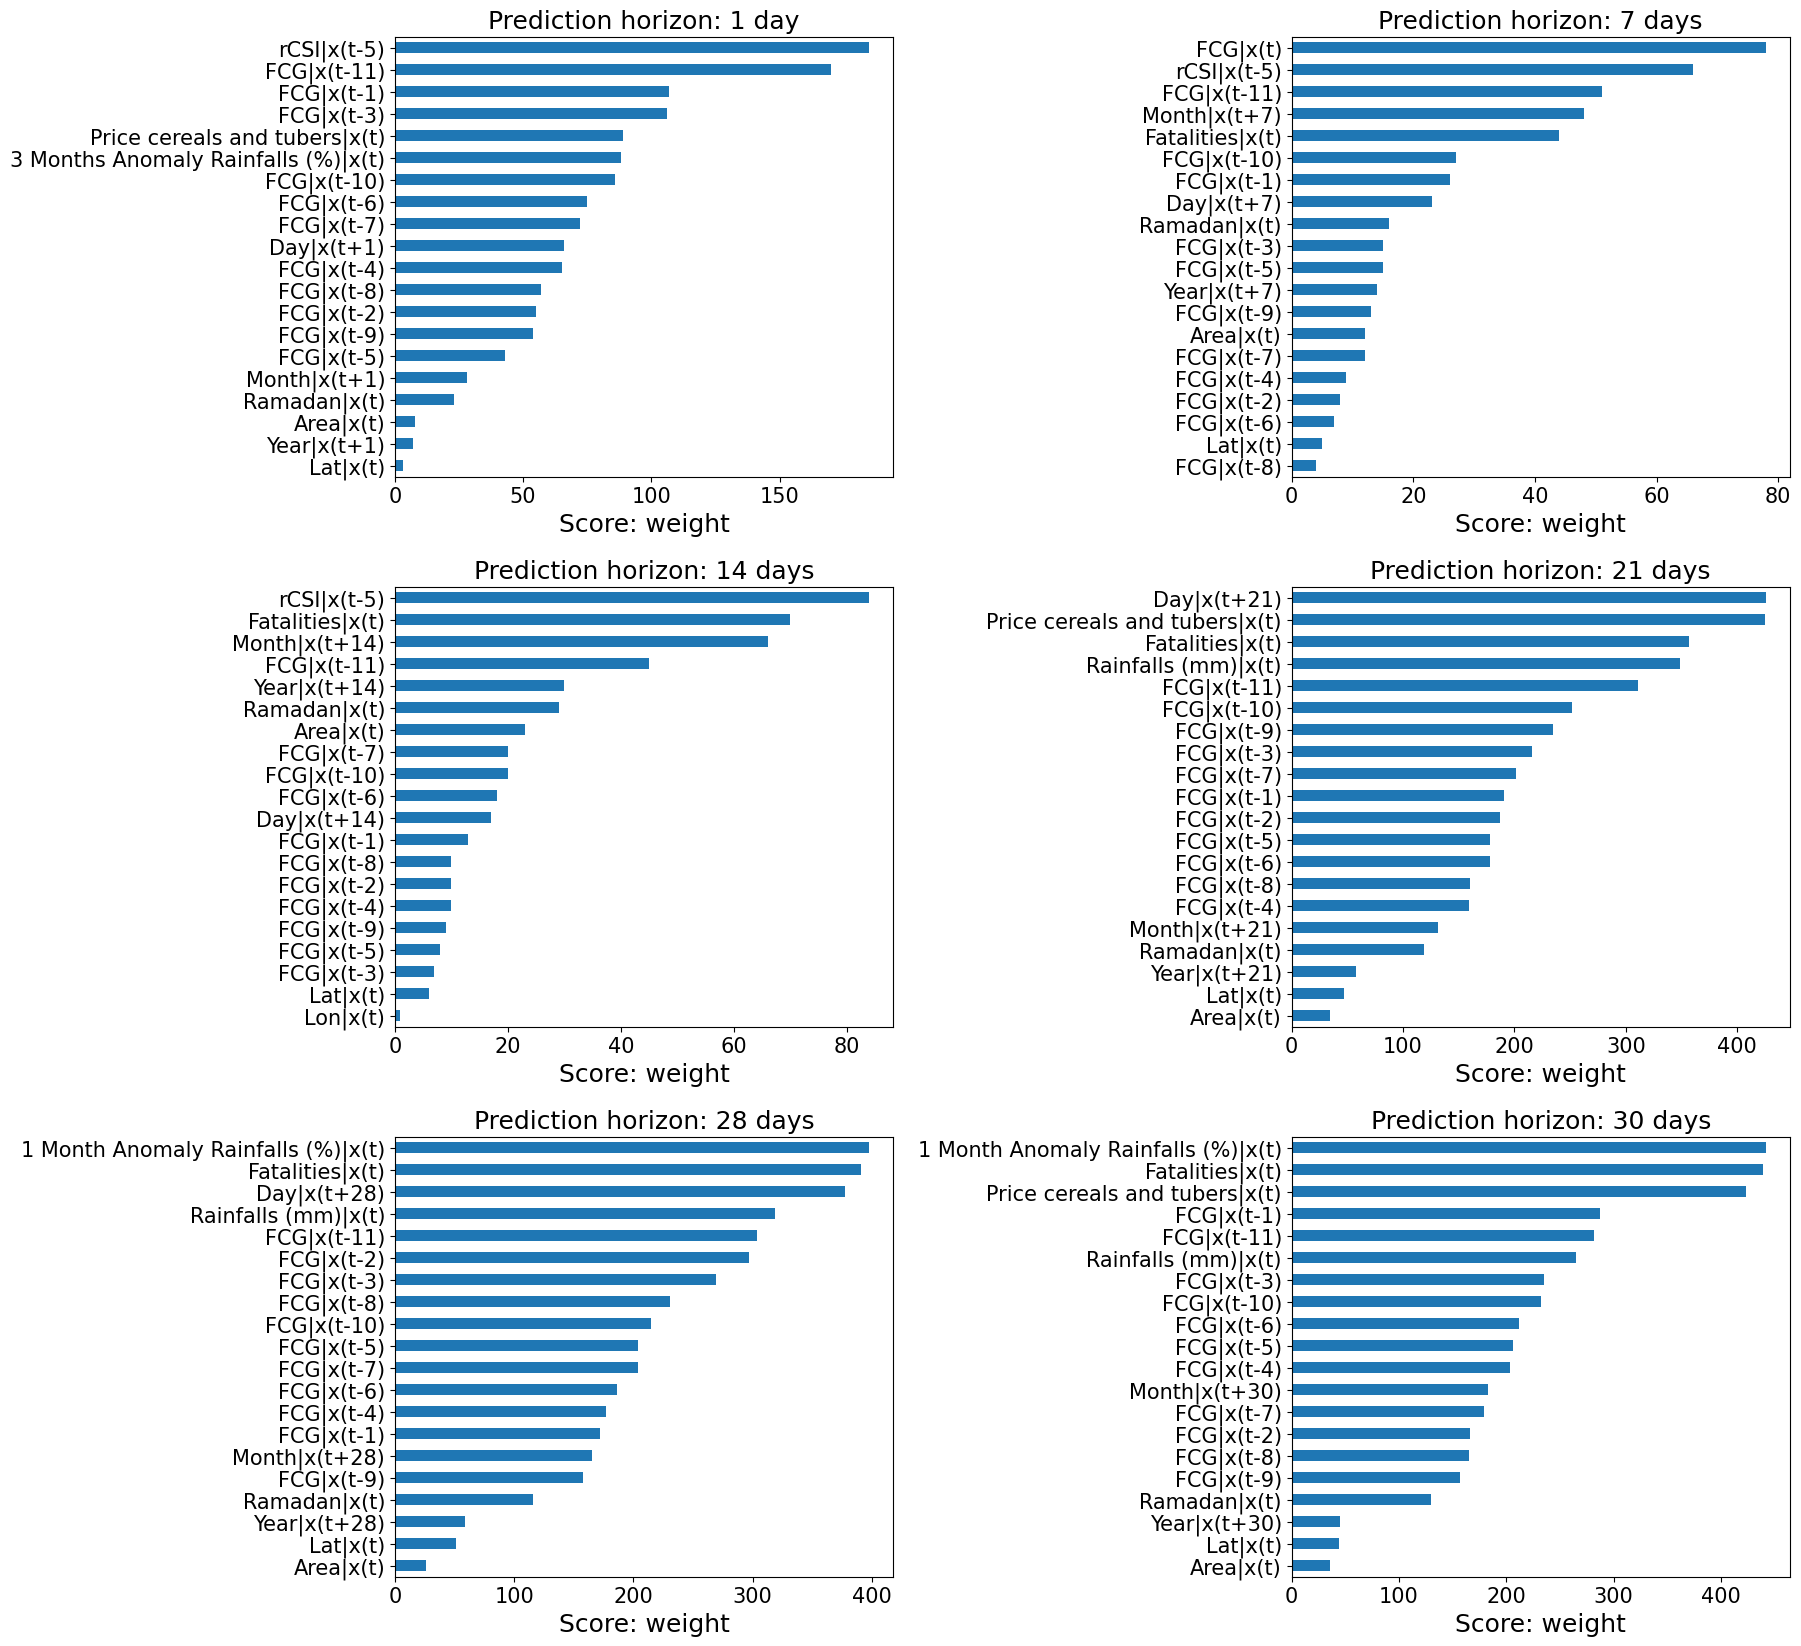

In [17]:
## Features importance.
prediction_horizons = [1, 7, 14, 21, 28, 30]

# Select last split to compute feature importance.
SPLIT = max(map(lambda x: int(re.findall(r"\b\d+\b", x)[0]), forecast_splits.columns.get_level_values(0)))

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 20))
fig.subplots_adjust(wspace = 0.8, hspace = 0.25)

axs = axs.ravel()
for i, h in enumerate(prediction_horizons):
    with open(f"{DIR_RESULTS}/standard/out_test/features_importance/features_split_{SPLIT}_h_{h}", "rb") as fp:
        f_imp = pickle.load(fp)
    
    # Create histogram feature importance.
    keys = list(f_imp.keys())
    values = list(f_imp.values())
    data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = True)   
    data = data.head(20)
    data.plot(kind = "barh", ax = axs[i])
    if h == 1:
        axs[i].set_title(f"Prediction horizon: {h} day")
    else:
        axs[i].set_title(f"Prediction horizon: {h} days")
    axs[i].legend_ = None
    axs[i].set_xlabel("Score: weight")
      
fig.savefig(f"{OUTPUT_FOLDER}/importance.png", bbox_inches = "tight", dpi = 300)